### Import Required Packages

In [85]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack, csr_matrix

### Logistic Regression

In [86]:
# Insert Qwen labelled data
train_data = pd.read_csv("../data/with_features/qwen_labelled_combined_reviews_with_features.csv")

# Insert hand labelled data
test_data = pd.read_csv("../data/with_features/hand_labelled_combined_reviews_with_features.csv")

X_train= train_data[["review_text", "rating", "review_length","sentiment", "all_caps_ratio","relevancy_score", "emotions"]]
y_train= train_data["label"]

X_test=test_data[["review_text", "rating", "review_length","sentiment", "all_caps_ratio","relevancy_score", "emotions"]]
y_test=test_data["label"]

X_train, X_test, y_train, y_test

(                                           review_text  ...               emotions
 0    Andrea is amazing. Our dog loves her and she a...  ...             admiration
 1    Andrea does a wonderful  job  with our wild Pr...  ...  admiration, gratitude
 2                                    Never called back  ...                neutral
 3                         They don't answer the phones  ...                neutral
 4                   Limited information on the website  ...                neutral
 ..                                                 ...  ...                    ...
 995                      Brett Williams is awesome!!!!  ...             admiration
 996  they have they the kinds of cars a teen will n...  ...                neutral
 997  I would not go back there for nothing, the gen...  ...                   none
 998                                     Awesome prices  ...             admiration
 999                           Not the best but alright  ...                

In [87]:
# Combine 'review_text' and 'emotions' into a new column for TF-IDF
X_train_combined = X_train["review_text"].fillna('') + " " + X_train["emotions"].fillna('')
X_test_combined = X_test["review_text"].fillna('') + " " + X_test["emotions"].fillna('')

# Apply TF-IDF to the combined text
tfidf = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_combined)
X_test_tfidf = tfidf.transform(X_test_combined)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1000, 5000)
(200, 5000)


In [88]:
# Numeric features 

# Store as numeric arrays
numeric_cols = ["rating", "review_length","sentiment", "all_caps_ratio","relevancy_score"]
X_train_numeric = X_train[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test_numeric  = X_test[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0).values

# Combine TF-IDF + numeric
X_train_final = hstack([X_train_tfidf, X_train_numeric])
X_test_final = hstack([X_test_tfidf, X_test_numeric])

print(X_train_final.shape)
print(X_test_final.shape)

(1000, 5005)
(200, 5005)


### Train Model

In [89]:
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train_final, y_train)

y_pred = clf.predict(X_test_final)

/Users/vaisiyabalakrishnan/techjam/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Results

In [90]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          Ad       0.22      0.20      0.21        10
  Irrelevant       0.03      0.29      0.06         7
        Rant       0.77      0.71      0.74        14
       Valid       0.94      0.67      0.78       169

    accuracy                           0.64       200
   macro avg       0.49      0.47      0.45       200
weighted avg       0.86      0.64      0.73       200



### Visualisations

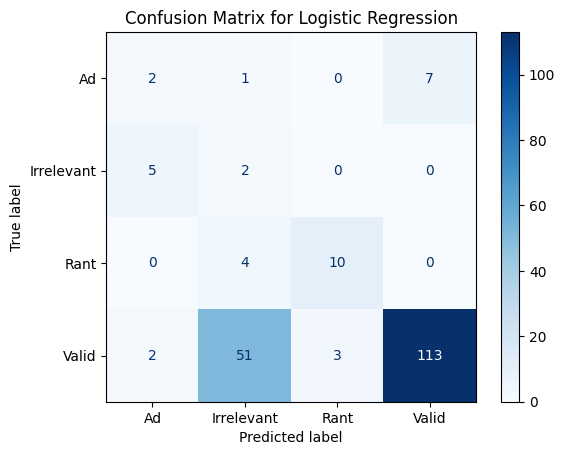

In [91]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')

plt.title('Confusion Matrix for Logistic Regression')
plt.show()

### Walkthrough

In [92]:
# New reviews for walkthrough
data_path = '../data/walk_through/walk_through.csv'
new_reviews = pd.read_csv(data_path).copy()

# Combine 'review_text' and 'emotions' columns for TF-IDF (same as training)
new_combined = new_reviews["review_text"].fillna('') + " " + new_reviews["emotions"].fillna('')

# Transform inputs using the same TF-IDF vectorizer
new_tfidf = tfidf.transform(new_combined)

# Map sentiment strings to numbers
sentiment_map = {"POSITIVE": 1, "NEGATIVE": -1, "NEUTRAL": 0}
new_reviews["sentiment_num"] = new_reviews["sentiment"].map(sentiment_map)

# Select numeric features
numeric_cols = ["rating", "review_length", "sentiment_num", "all_caps_ratio", "relevancy_score"]
new_numeric = new_reviews[numeric_cols].astype(float).values
new_numeric_sparse = csr_matrix(new_numeric)

# Combine features
new_final = hstack([new_tfidf, new_numeric_sparse])

# Predictions
predictions = clf.predict(new_final)

# Compare true vs predicted
for review, true_label, pred in zip(new_reviews["review_text"], new_reviews["label"], predictions):
    print(f"Review: {review}\n   True: {true_label} --> Predicted: {pred}\n")


Review: I’ve had my Sanctuary 2 sauna and red light for about a month and love it! Julie is very knowledgeable and was a great help in picking the right sauna. Thanks Julie!
   True: Valid --> Predicted: Valid

Review: What can I say! Julie was fantastic and the product ( Sactuary 3) is fantastic as well. I came across Julie by chance on the internet and her 24/7 availability by text just blew me away. She knows she represents  a top notch aesthetic and performance product that becomes part of your daily routine.  Thank you Julie and Clearlight for making this life experience healthier and fun!
   True: Valid --> Predicted: Valid

Review: Thank you so much Julie for your support in purchasing this Clearlight Sauna -1! It's compact and fits perfectly in my bedroom. The quality is unparalleled! It heats up in about 20 minutes. The color changes for treating different body systems is great.

Not only is the sauna top notch, but Julie's service is top notch. I message her early morning or 

In [93]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(new_reviews["label"], predictions)
print("Accuracy:", accuracy)

Accuracy: 0.98
